In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency, ttest_ind

file_path = r"C:\Users\jg275\Downloads\archive (5)\US_Accidents_March23.csv"
useful_columns = [
    'ID', 'Start_Time', 'End_Time', 'Severity', 'Weather_Condition', 
    'Visibility(mi)', 'Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)', 
    'City', 'State', 'Start_Lat', 'Start_Lng']

print("Loading dataset...")
df = pd.read_csv(file_path, usecols=useful_columns, nrows=100000,encoding="latin1")
print("Initial data shape:", df.shape)

Loading dataset...
Initial data shape: (100000, 13)


In [2]:
if not pd.api.types.is_datetime64_any_dtype(df['Start_Time']):
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Remove rows with invalid datetime conversion
df.dropna(subset=['Start_Time'], inplace=True)

# Feature engineering
try:
    df['Hour'] = df['Start_Time'].dt.hour
except Exception as e:
    print("Error extracting 'Hour':", e)
    df['Hour'] = pd.to_datetime(df['Start_Time'], errors='coerce').dt.hour

In [3]:
# 2: Data Preprocessing

print("\nCleaning data...")
# Drop rows with missing values
df.dropna(inplace=True)
print("Data shape after dropping nulls:", df.shape)

df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek 


Cleaning data...
Data shape after dropping nulls: (75041, 14)


In [4]:
def time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['TimeOfDay'] = df['Hour'].apply(lambda x: time_period(x) if pd.notnull(x) else 'Unknown')
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek

C:\Users\jg275\AppData\Local\Temp\ipykernel_9056\282087887.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df, palette='coolwarm')


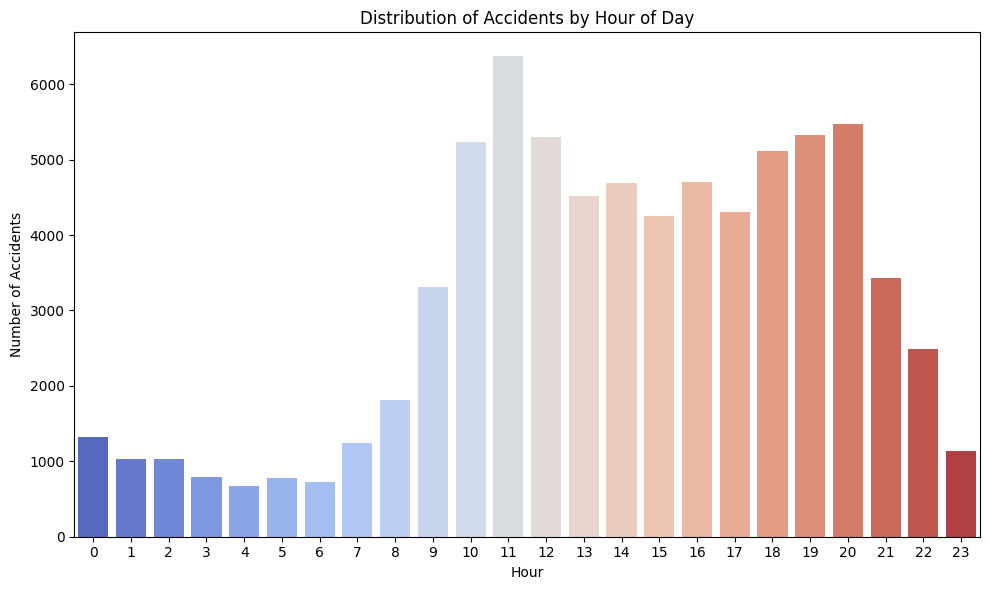

In [5]:
#1: Accidents by Hour of Day
plt.figure(figsize=(10,6))
sns.countplot(x='Hour', data=df, palette='coolwarm')
plt.title("Distribution of Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()


Top weather conditions involved in accidents:
Index(['Clear', 'Overcast', 'Partly Cloudy', 'Mostly Cloudy',
       'Scattered Clouds', 'Light Rain', 'Haze', 'Fair', 'Rain', 'Heavy Rain'],
      dtype='object', name='Weather_Condition')


C:\Users\jg275\AppData\Local\Temp\ipykernel_9056\1994596651.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Weather_Condition', data=df_weather, order=top_weather, palette='viridis')


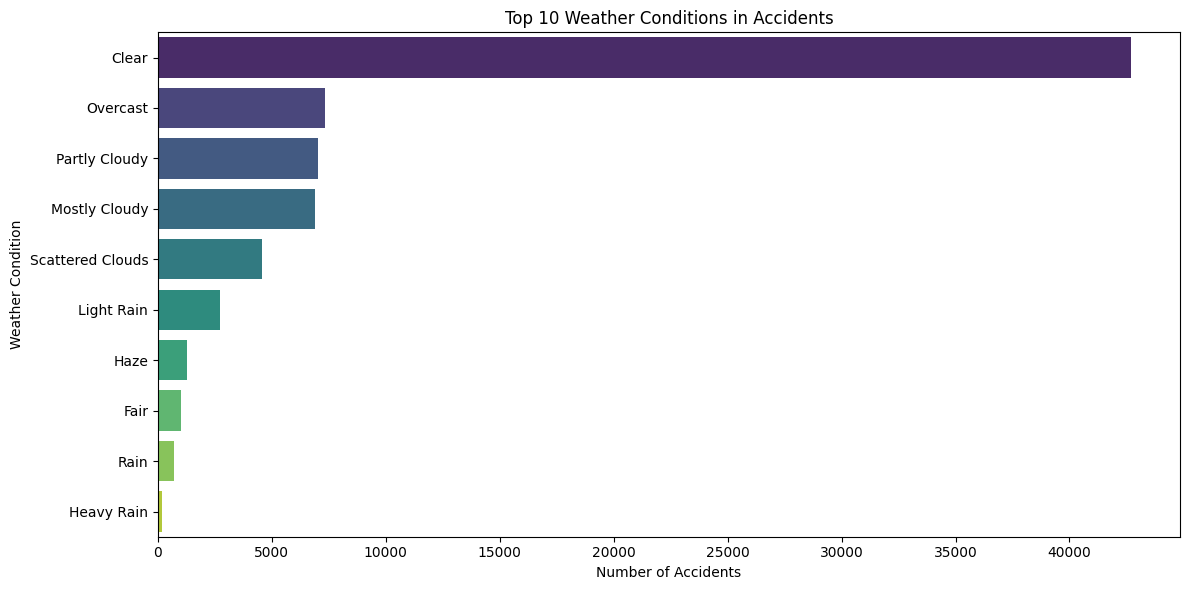

In [6]:
# 2: Accidents by Weather Condition
print("\nTop weather conditions involved in accidents:")
top_weather = df['Weather_Condition'].value_counts().nlargest(10).index
print(top_weather)
df_weather = df[df['Weather_Condition'].isin(top_weather)]

plt.figure(figsize=(12,6))
sns.countplot(y='Weather_Condition', data=df_weather, order=top_weather, palette='viridis')
plt.title("Top 10 Weather Conditions in Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.show()

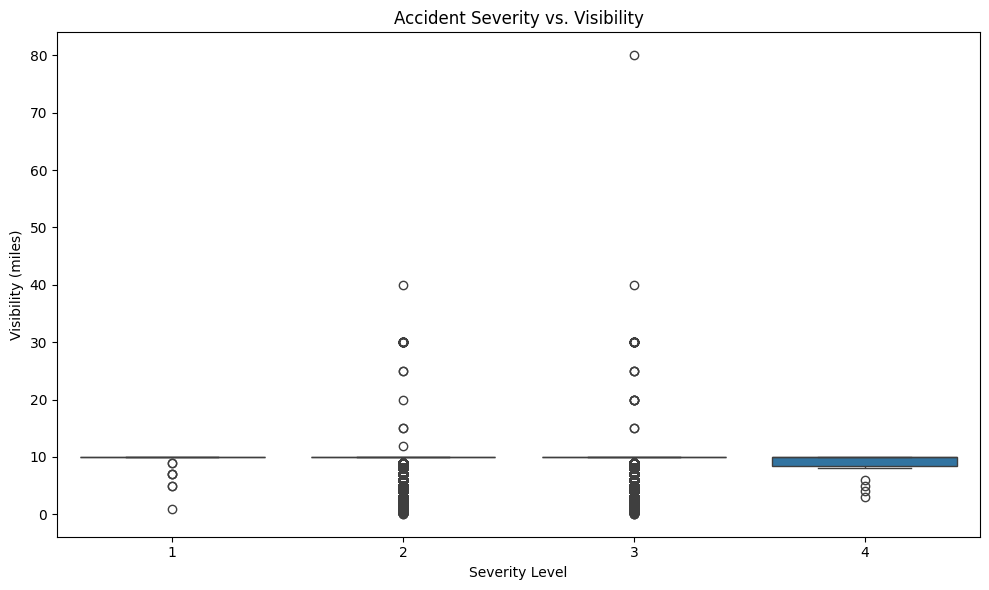

In [7]:
#3: Severity vs Visibility
plt.figure(figsize=(10,6))
sns.boxplot(x='Severity', y='Visibility(mi)', data=df)
plt.title("Accident Severity vs. Visibility")
plt.xlabel("Severity Level")
plt.ylabel("Visibility (miles)")
plt.tight_layout()
plt.show()

C:\Users\jg275\AppData\Local\Temp\ipykernel_9056\3553945206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TimeOfDay', data=df, order=['Morning','Afternoon','Evening','Night'], palette='magma')


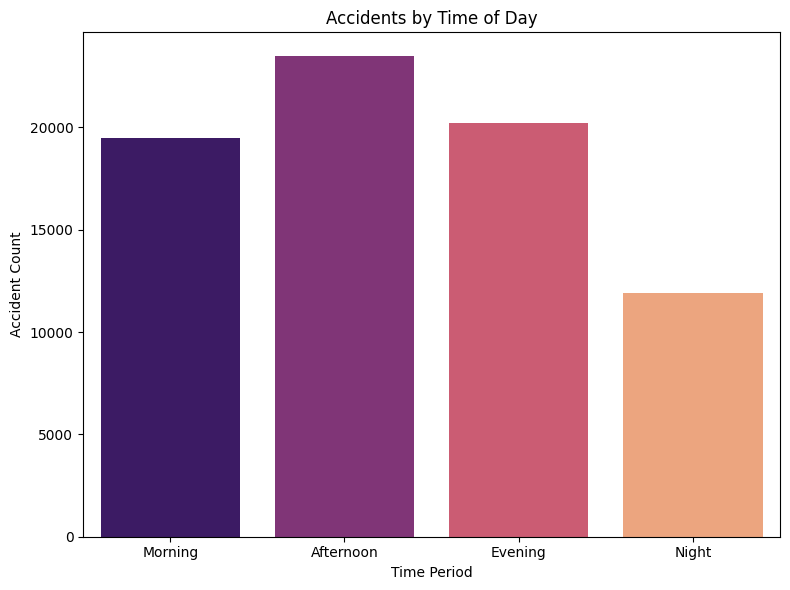

In [13]:
# 4: Accidents by Time of Day
plt.figure(figsize=(8,6))
sns.countplot(x='TimeOfDay', data=df, order=['Morning','Afternoon','Evening','Night'], palette='magma')
plt.title("Accidents by Time of Day")
plt.xlabel("Time Period")
plt.ylabel("Accident Count")
plt.tight_layout()
plt.show()# 4: Accidents by Time of Day


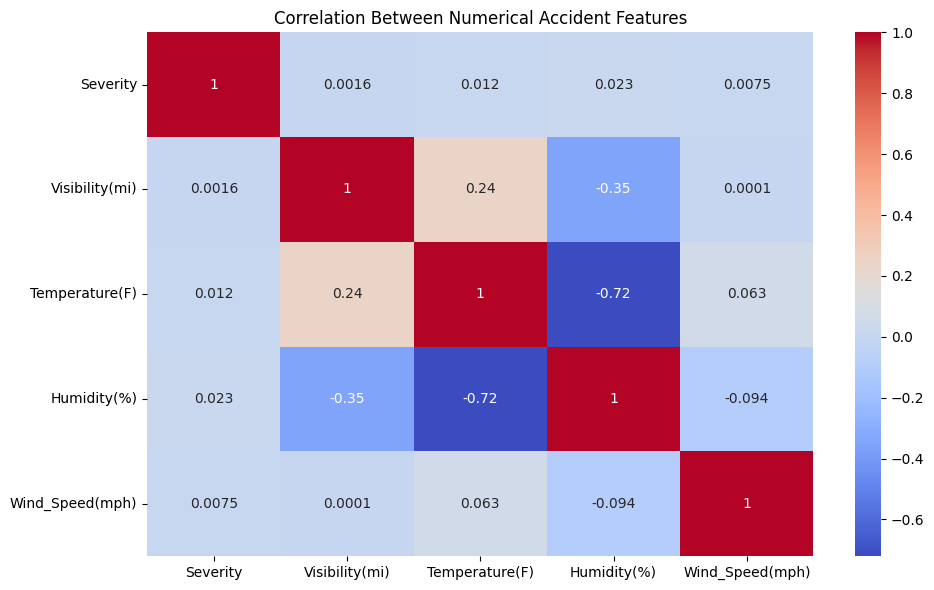

In [9]:
# 5: Correlation Matrix
numeric_cols = ['Severity', 'Visibility(mi)', 'Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)']
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numerical Accident Features")
plt.tight_layout()
plt.show()


In [10]:
# Step 5: Statistical Testing

# Chi-Square Test between Severity and TimeOfDay
contingency_table = pd.crosstab(df['Severity'], df['TimeOfDay'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test between Severity and TimeOfDay")
print("Chi2 Statistic:", chi2)
print("p-value:", p)



Chi-Square Test between Severity and TimeOfDay
Chi2 Statistic: 46.87365348929134
p-value: 4.143147644732612e-07


In [15]:
# 6: Predictive Modeling

print("\nRunning Decision Tree Classifier...")
features = df[['Visibility(mi)', 'Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)', 'Hour']]
target = df['Severity']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay=confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))


Running Decision Tree Classifier...

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.57      0.79      0.66     12292
           3       0.52      0.27      0.36     10201
           4       0.00      0.00      0.00         5

    accuracy                           0.55     22513
   macro avg       0.27      0.27      0.25     22513
weighted avg       0.54      0.55      0.52     22513


Confusion Matrix:
[[   0   13    2    0]
 [   0 9710 2582    0]
 [   0 7441 2760    0]
 [   0    3    2    0]]


C:\Users\jg275\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jg275\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jg275\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

C:\Users\jg275\AppData\Local\Temp\ipykernel_9056\3131620248.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='crest')


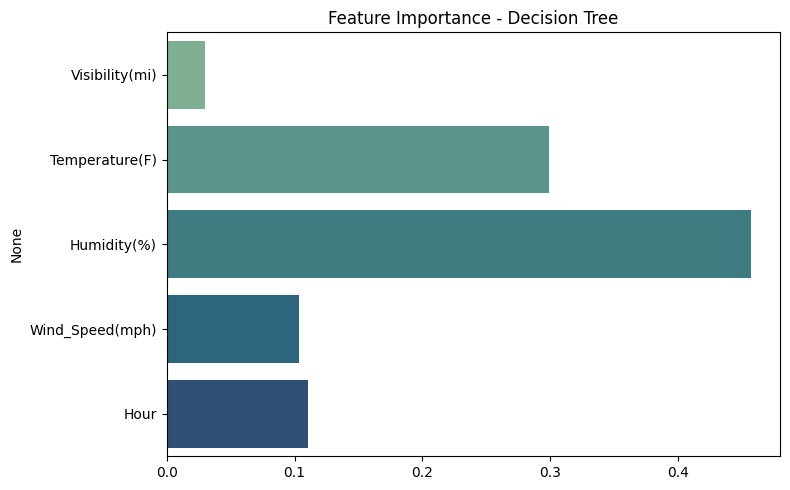

<Figure size 600x400 with 0 Axes>

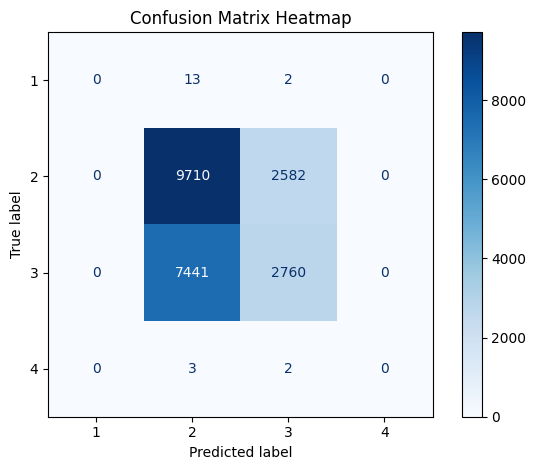


Model Accuracy: 55.39%


In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

# --- Feature Importance ---
importances = model.feature_importances_
feature_names = features.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, palette='crest')
plt.title("Feature Importance - Decision Tree")
plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()

# --- Accuracy ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")
